# Demo: Shallow Water Model

In [1]:
import jax
# again, this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

In [2]:
import autoroot
from typing import Optional
from jaxtyping import Array

import jax
import jax.numpy as jnp
import equinox as eqx
from somax.domain import Domain, TimeDomain
from somax.interp import x_avg_2D, y_avg_2D, center_avg_2D
from somax.operators import difference, relative_vorticity, relative_vorticity, kinetic_energy
from somax.masks import MaskGrid, FaceMask, CenterMask, NodeMask
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


%load_ext autoreload
%autoreload 2

In [3]:

# from finitevolx import MaskGrid, x_avg_2D, y_avg_2D, center_avg_2D, difference, relative_vorticity, reconstruct, kinetic_energy
# from somax._src.models.sw.params import SWMParams
# from somax._src.models.sw.operators import (
#     h_linear_rhs, h_nonlinear_rhs, 
#     u_linear_rhs, u_nonlinear_rhs, 
#     v_linear_rhs, v_nonlinear_rhs,
#     potential_vorticity, kinetic_energy, 
#     calculate_uvh_flux
# )
# from somax._src.boundaries import zero_gradient_boundaries, no_slip_boundaries, no_flux_boundaries
# from somax._src.operators.flux import uv_center_flux, uv_node_flux
# # from somax._src.models.sw.boundaries import wall_boundaries
# from somax._src.boundaries.wall import wall_boundaries_2D
# from somax._src.models.sw.initial import (
#     init_partition, init_h0_jet, 
# )

# import matplotlib.pyplot as plt
# import numpy as np

# %matplotlib inline


# %load_ext autoreload
# %autoreload 2

In [4]:
def plot_field(field):
    num_axis = len(field)
    fig, ax = plt.subplots(figsize=(8, 2))

    pts = ax.imshow(field.T, origin="lower", cmap="coolwarm")
    plt.colorbar(pts)

    plt.tight_layout()
    plt.show()

## Domain

In [5]:
Nx, Ny = 200, 104
dx, dy = 5e3, 5e3
Lx, Ly = Nx * dx, Ny * dy

In [6]:
h_domain = Domain(xmin=(0.0, 0.0), xmax=(Lx, Ly), Lx=(Lx,Ly), Nx=(Nx,Ny), dx=(dx,dy))
u_domain = Domain(xmin=(-0.5, 0.0), xmax=(Lx+0.5*dx, Ly), Lx=(Lx+dx,Ly), Nx=(Nx+1,Ny), dx=(dx,dy))
v_domain = Domain(xmin=(0.0, -0.5), xmax=(Lx, Ly+0.5*dy), Lx=(Lx,Ly+0.5*dy), Nx=(Nx,Ny+1), dx=(dx,dy))
q_domain = Domain(xmin=(-0.5,-0.5), xmax=(Lx+0.5*dx, Ly+0.5*dy), Lx=(Lx+dx,Ly+dy), Nx=(Nx+1,Ny+1), dx=(dx,dy))
u_domain, v_domain, q_domain
h_domain

Domain(
  xmin=(0.0, 0.0),
  xmax=(1000000.0, 520000.0),
  dx=(5000.0, 5000.0),
  Nx=(200, 104),
  Lx=(1000000.0, 520000.0),
  ndim=2
)

In [7]:
# class ArakawaCDomain(eqx.Module):
class StateDomain(eqx.Module): 
    h: Domain = eqx.field(static=True)
    u: Domain = eqx.field(static=True)
    v: Domain = eqx.field(static=True)
    q: Domain = eqx.field(static=True)

In [8]:
domain = ArakawaCDomain(h=h_domain, u=u_domain, v=v_domain, q=q_domain)

## Model Parameter

In [9]:
from somax._src.models.sw.params import SWMParams

params = SWMParams(
    gravity=9.81, depth=100.0, coriolis_f0=2e-4, coriolis_beta=2e-11,
    linear_mass=False, linear_momentum=False,
    mass_num_pts=5, mass_method="wenoz",
    mom_num_pts=5, mom_method="wenoz"
)

### Mask

In [10]:
mask = jnp.ones(domain.h.Nx)
masks = MaskGrid.init_mask(mask, "center")

In [11]:
masks.node.values

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

### Initial Conditions

#### Zonal Velocity

In [12]:
from somax._src.models.sw.initial import init_partition

u0 = init_partition(domain.u)


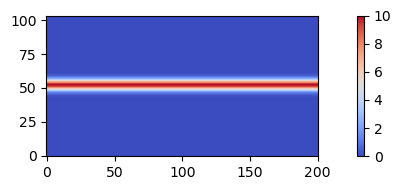

In [13]:
plot_field(u0)

#### Meridional Velocity, V

In [14]:
v0 = jnp.zeros(domain.v.Nx)
u0.shape, v0.shape

((201, 104), (200, 105))

#### Height

In [15]:
from somax._src.models.sw.initial import init_h0_jet

h0 = init_h0_jet(domain.h, params, u0=u0)

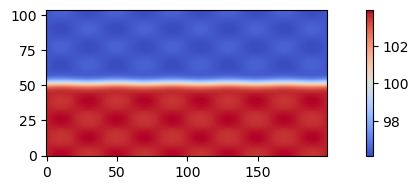

In [16]:
plot_field(h0)

### Boundary Conditions

In [17]:
from somax._src.boundaries.wall import wall_boundaries_2D
from somax._src.boundaries import zero_gradient_boundaries


bc_fn = wall_boundaries_2D

### State

In [18]:
class State(eqx.Module):
    h: Array
    u: Array
    v: Array

In [19]:
state = State(h=h0, u=u0, v=v0)

## Equation of Motion


In [20]:
from somax._src.operators.flux import uv_center_flux

# zero flux padding
h_pad = zero_gradient_boundaries(state.h, ((1, 1), (1, 1)))

uh_flux, vh_flux = uv_center_flux(
    h=h_pad, v=state.v, u=state.u, 
    u_mask=masks.face_u, v_mask=masks.face_v,
    num_pts=params.mass_num_pts, method=params.mass_method
)

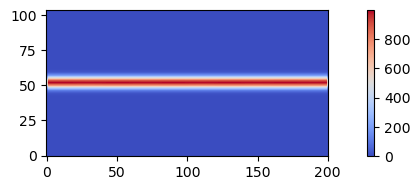

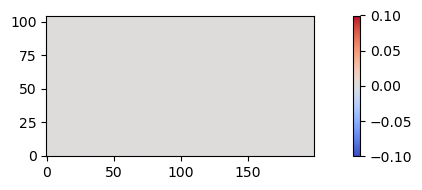

In [21]:
plot_field(uh_flux)
plot_field(vh_flux)

In [22]:
from somax._src.models.sw.operators import potential_vorticity

q = potential_vorticity(
    h=h0, u=u0, v=v0, 
    dx=h_domain.dx[0], dy=h_domain.dx[1], 
    q_domain=q_domain,
    params=params, node_mask=masks.node
)

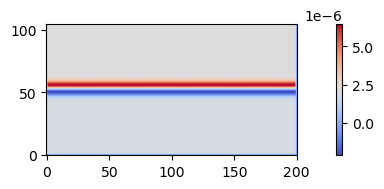

In [23]:
plot_field(q)

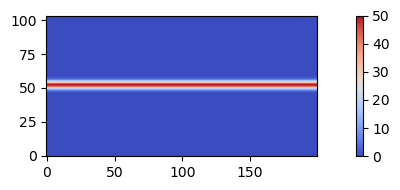

In [24]:
from somax._src.models.sw.operators import kinetic_energy


ke = kinetic_energy(u=u0, v=v0, center_mask=masks.center)

plot_field(ke)

In [25]:
from somax._src.models.sw.operators import u_nonlinear_rhs, v_nonlinear_rhs


u_rhs = u_nonlinear_rhs(
    h=h0, q=q, 
    vh_flux=vh_flux, ke=ke,
    dx=dx, params=params, 
    num_pts=params.mom_num_pts, method=params.mom_method,
    u_mask=masks.face_u
)
v_rhs = v_nonlinear_rhs(
    h=h0, q=q, 
    uh_flux=uh_flux, ke=ke,
    dy=dy, params=params, 
    num_pts=params.mom_num_pts, method=params.mom_method,
    v_mask=masks.face_v
)



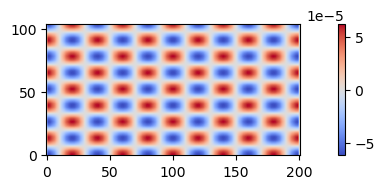

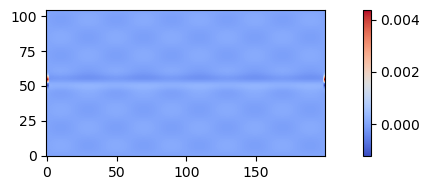

In [26]:
plot_field(u_rhs)
plot_field(v_rhs)

### Vector Field

In [27]:
from somax._src.operators.flux import uv_center_flux
from somax._src.models.sw.operators import h_linear_rhs, h_nonlinear_rhs
def equation_of_motion(h, u, v, masks, params):
    
    
    
    if not params.linear_mass or not params.linear_momentum:
        
        # zero flux padding
        h_pad: Float[Array, "Nx+2 Ny+2"] = zero_gradient_boundaries(h, ((1, 1), (1, 1)))
        
        # calculate mass fluxes
        uh_flux, vh_flux = uv_center_flux(
            h=h_pad, v=v, u=u, 
            u_mask=masks.face_u, v_mask=masks.face_v,
            num_pts=params.mass_num_pts, method=params.mass_method,
        )


    # mass equation
    
    if params.linear_mass:
        h_rhs = h_linear_rhs(
            u=u, v=v, dx=domain.h.dx[0], dy=domain.h.dx[1], params=params, 
            center_mask=masks.center
        )
        
    else:
        h_rhs = h_nonlinear_rhs(
            uh_flux=uh_flux,
            vh_flux=vh_flux, 
            dx=domain.h.dx[0], 
            dy=domain.h.dx[1],  
            center_mask=masks.center
        )

    # momentum equations

    if params.linear_momentum:
        u_rhs = u_linear_rhs(
            h=h, v=v, dx=domain.u.dx[0], 
            params=params, u_mask=masks.face_u
        )
        v_rhs = v_linear_rhs(h=h, u=u, dy=domain.v.dx[1], 
                            params=params, v_mask=masks.face_v)
    else:
        # calculate kinetic energy
        ke = kinetic_energy(u=u, v=v, center_mask=masks.center)
        
        # calculate potential vorticity
        q = potential_vorticity(
            h=h, u=u, v=v, 
            dx=domain.h.dx[0], dy=domain.h.dx[1], 
            q_domain=domain.q,
            params=params, 
            node_mask=masks.node
        )
        
        # calculate RHS u
        u_rhs = u_nonlinear_rhs(
            h=h, q=q, 
            vh_flux=vh_flux, ke=ke,
            dx=domain.h.dx[0], params=params, 
            num_pts=params.mom_num_pts, method=params.mom_method,
            u_mask=masks.face_u
        )
        
        # calculate RHS v
        v_rhs = v_nonlinear_rhs(
            h=h, q=q, 
            uh_flux=uh_flux, ke=ke,
            dy=domain.h.dx[1], params=params, 
            num_pts=params.mom_num_pts, method=params.mom_method,
            v_mask=masks.face_v
        )
        
        
    return h_rhs, u_rhs, v_rhs

In [28]:
def vector_field(t: float, state: State, args):
    
    params, domain, masks = args
    
    h, u, v = state.h, state.u, state.v
    
    # calculate RHS
    h_rhs, u_rhs, v_rhs = equation_of_motion(
        h=h, u=u, v=v, masks=masks, params=params
    )
    
    # update state
    state = eqx.tree_at(lambda x: x.h, state, h_rhs)
    state = eqx.tree_at(lambda x: x.u, state, u_rhs)
    state = eqx.tree_at(lambda x: x.v, state, v_rhs)
    
    return state

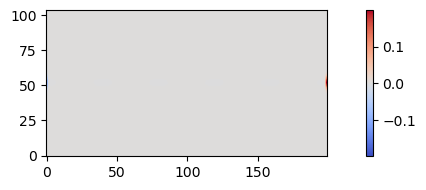

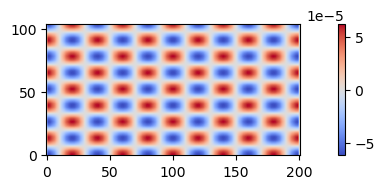

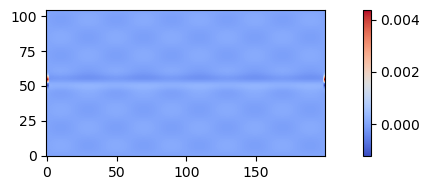

In [29]:
state_ = vector_field(0, state, (params, domain, masks))


plot_field(state_.h)
plot_field(state_.u)
plot_field(state_.v)

## TIme Integration

In [59]:
import pandas as pd
import diffrax as dfx


dt = 0.125 * min(h_domain.dx[0], h_domain.dx[1]) / jnp.sqrt(params.gravity * params.depth)

tmin = 0.0
num_years = 5
num_days = 2.0
tmax = pd.to_timedelta(num_years * num_days, unit="days").total_seconds()
num_save = 10

In [60]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

In [61]:
ts

Array([     0.,  96000., 192000., 288000., 384000., 480000., 576000.,
       672000., 768000., 864000.], dtype=float64)

In [62]:

# solver = dfx.Tsit5()
solver = dfx.Bosh3()
# solver = dfx.EulerHeun()
# solver = dfx.Euler()
# stepsize_controller = dfx.ConstantStepSize() 
stepsize_controller = dfx.PIDController(rtol=1e-4, atol=1e-4)

In [63]:
# initialize parameters
params = SWMParams(
    gravity=9.81, depth=100.0, 
    coriolis_f0=2e-4, 
    coriolis_beta=2e-11,
    linear_mass=False, 
    linear_momentum=False,
    mass_num_pts=3, mass_method="linear",
    mom_num_pts=3, mom_method="linear"
)
# initialize state
state = State(h=h0, u=u0, v=v0)

In [64]:
jax.__version__

'0.4.26'

In [65]:
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=state,
    saveat=saveat,
    args=(params, domain, masks),
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

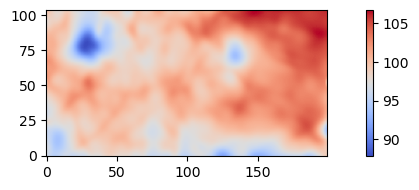

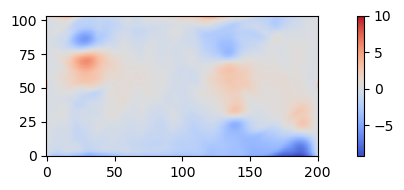

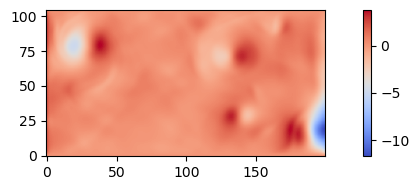

In [66]:
plot_field(sol.ys.h[-1])
plot_field(sol.ys.u[-1])
plot_field(sol.ys.v[-1])

In [77]:
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=State(h=sol.ys.h[-1], u=sol.ys.u[-1], v=sol.ys.v[-1]),
    saveat=saveat,
    args=(params, domain, masks),
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

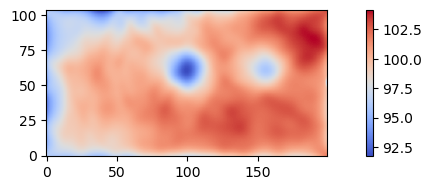

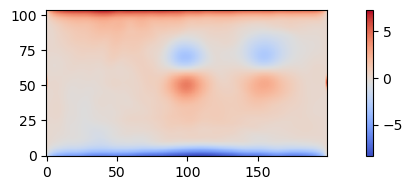

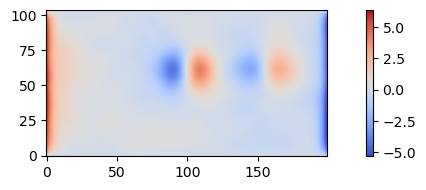

In [78]:
plot_field(sol.ys.h[-1])
plot_field(x_avg_2D(sol.ys.u[-1]))
plot_field(y_avg_2D(sol.ys.v[-1]))